# Approximate Graph Propagation v2

In [2]:
import numpy as np
import scipy
import pandas as pd
import requests
from os import makedirs, path, listdir, remove
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
from shutil import rmtree
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
import matplotlib
from matplotlib import cm
from datetime import datetime

import httplib2
import geopandas as gpd
from tqdm import tqdm
from typing import Tuple, List, Optional, Union


## Get LAQN Data

In [3]:
species = "NO2"
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"
data_folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code"
data_filename = f"LAQN_{species}_{start_date}_{end_date}.csv"

In [4]:
# Load LAQN data
laqn_df = pd.read_csv(path.join(data_folder, data_filename), index_col="date", infer_datetime_format=True)
print(laqn_df.shape)

(219169, 201)


(33, 10)


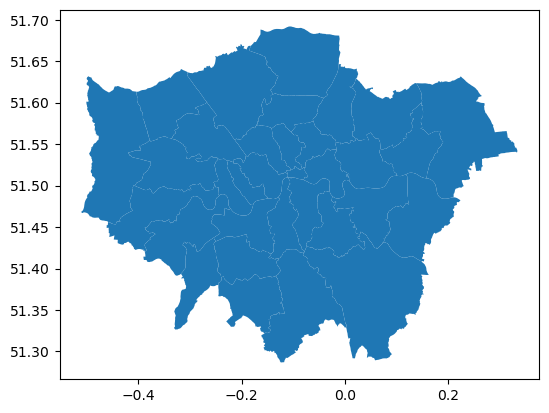

In [5]:
# Load map file
folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/Andrea_data/shape_files/london_boroughs"
london_boroughs_gdf = gpd.read_file(path.join(folder, "london_boroughs_coordinates.shp"))
#london_gdf = london_boroughs_gdf.dissolve()
print(london_boroughs_gdf.shape)
london_boroughs_gdf.plot()
plt.show()

(248, 17)


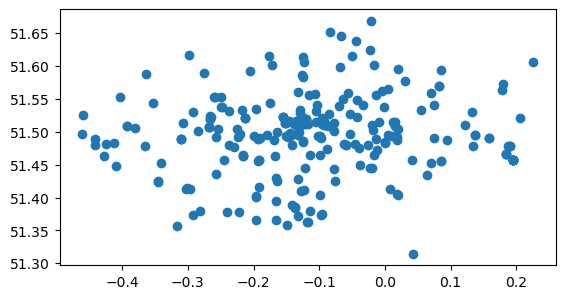

In [6]:
# Load LAQN metadata
folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/Andrea_data/shape_files/LAQN_sites"
london_sites_gdf = gpd.read_file(path.join(folder, "LAQN_sites.shp"))
print(london_sites_gdf.shape)
london_sites_gdf.plot()
plt.show() 

In [7]:
london_sites_gdf

,@LocalAuth,@LocalAu_1,@SiteCode,@SiteName,@SiteType,@DateClose,@DateOpene,@Latitude,@Longitude,@LatitudeW,@Longitu_1,@DisplayOf,@Display_1,@DataOwner,@DataManag,@SiteLink,geometry
0,27,Richmond,TD0,"- National Physical Laboratory, Teddington",Suburban,2018-01-01 00:00:00,1996-08-08 00:00:00,51.4243043441456,-0.345714576446947,6696103.27675,-37808.8858115,0,-200,Richmond,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.34571 51.42430)
1,1,Barking and Dagenham,BG3,Barking and Dagenham - North Street,Kerbside,2011-05-25 00:00:00,2007-03-16 00:00:00,51.540444,0.074418,6717454.5833,8284.17386585,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.07442 51.54044)
2,1,Barking and Dagenham,BG1,Barking and Dagenham - Rush Green,Suburban,None,1999-11-02 00:00:00,51.563752,0.177891,6721627.34498,19802.7355367,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.17789 51.56375)
3,1,Barking and Dagenham,BG2,Barking and Dagenham - Scrattons Farm,Suburban,None,1999-10-17 00:00:00,51.529389,0.132857,6715476.18683,14789.5735883,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.13286 51.52939)
4,2,Barnet,BN2,Barnet - Finchley,Urban Background,2012-04-20 00:00:00,2000-08-09 13:00:00,51.591901,-0.205992,6726669.62886,-22930.9245475,0,0,Barnet,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.20599 51.59190)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,33,Westminster,WMB,Westminster - Oxford Street East,Roadside,None,2018-06-05 00:00:00,51.516066,-0.13516388,6712710.23315,-17008.8057704,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.13516 51.51607)
244,33,Westminster,NB1,Westminster - Strand (Northbank BID),Roadside,None,2015-04-28 00:00:00,51.5119701188277,-0.116713103528546,6712364.87549212,-12992.6543679369,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.11671 51.51197)
245,33,Westminster,WM8,Westminster - Victoria,Urban Background,2016-04-04 00:00:00,2014-01-06 00:00:00,51.497066177578,-0.142438820740121,6709694.46727186,-15856.2169939846,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.14244 51.49707)
246,33,Westminster,WM9,Westminster - Victoria (Victoria BID),Roadside,2017-09-20 00:00:00,2016-08-08 00:00:00,51.4977331829735,-0.14424140916201,6709818.70995547,-16057.0573104942,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.14424 51.49773)


In [8]:
def plot_on_map(data_geodataframe: gpd.GeoDataFrame, 
                map_geodataframe: gpd.GeoDataFrame, 
                data_column: str = None, 
                map_column: str = None, 
                data_cmap: str = None, 
                map_cmap: str = None, 
                data_color: str = None, 
                map_color: str = "whitesmoke", 
                data_markersize_factor: float = 0.01,  # Relative to fontsize
                map_edge_color: str = "black", 
                colorbar: bool = False, 
                title: str = "Greater London", 
                fontsize: int = 25, 
                figsize: tuple = (20, 10), 
                axis: str = "off",
                mark: bool = False,
                mark_column: str = "@SiteCode") -> None:
    """
    Plot data on a geographic map using GeoPandas and Matplotlib.

    Parameters:
    - data_geodataframe: GeoDataFrame containing data to be plotted.
    - map_geodataframe: GeoDataFrame containing the base map.
    - data_column: Column in data_geodataframe used for coloring data points.
    - map_column: Column in map_geodataframe used for coloring the base map.
    - data_cmap: Colormap for data points.
    - map_cmap: Colormap for the base map.
    - data_color: Color for data points.
    - map_color: Color for the base map.
    - data_markersize_factor: Size factor of markers for data points relative to fontsize.
    - map_edge_color: Edge color for the base map.
    - colorbar: Boolean indicating whether to display a colorbar.
    - title: Title of the plot.
    - fontsize: Font size for the title and labels.
    - figsize: Size of the figure (width, height).
    - axis: Matplotlib axis parameter.
    - mark: Boolean indicating whether to mark specific data points on the map.
    - mark_column: Column used to filter data for marking.

    Returns:
    - None
    """
    
    # Calculate marker size based on fontsize
    data_markersize = fontsize * data_markersize_factor
    
    # Plot the base map
    base = data_geodataframe.plot(column=data_column, 
                                  ax=map_geodataframe.plot(column=map_column, 
                                                           figsize=figsize, 
                                                           color=map_color, 
                                                           edgecolor=map_edge_color, 
                                                           cmap=map_cmap), 
                                  color=data_color, cmap=data_cmap, markersize=data_markersize)
    
    # Add colorbar if specified
    if colorbar:
        colorbar_max = data_geodataframe[data_column].max()
        norm = plt.Normalize(data_geodataframe[data_column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)).set_label(data_column)
    
    # Mark specific points on the map if specified
    if mark:
        marked = data_geodataframe[data_geodataframe[mark_column] == mark]
        marked.plot(ax=base, marker='x', color='black', markersize=fontsize * 0.6)  # 0.6 is a relative size factor
    
    # Set plot title and axis labels
    plt.suptitle(title, fontsize=fontsize)
    plt.xlabel('Longitude', fontsize=fontsize * 0.7)  # 0.7 is a relative size factor
    plt.ylabel('Latitude', fontsize=fontsize * 0.7)  # 0.7 is a relative size factor
    
    # Set font sizes for ticks
    plt.xticks(fontsize=fontsize * 0.8)  # 0.8 is a relative size factor
    plt.yticks(fontsize=fontsize * 0.8)  # 0.8 is a relative size factor
    
    # Set axis parameter
    plt.axis(axis)
    
    # Display the plot
    plt.show()


## Graph Propagation

In [9]:
class Dataset():
    def __init__(self, csv_file):
        # Initialize Dataset object with a CSV file
        self.df = pd.read_csv(csv_file)
        # Store the original DataFrame for reference
        self.orig = self.df.copy()
        # Convert the 'date' column to datetime format
        self.df['date'] = pd.to_datetime(self.df['date'])

    def drop_null(self, nan_percent):
        # Drop columns where the proportion of NaN elements exceeds nan_percent
        min_count = int(((100 - nan_percent) / 100) * self.df.shape[0] + 1)
        return self.df.dropna(axis=1, thresh=min_count)

    def fill_mean(self):
        # Fill NaN values with the mean of each column
        return self.df.fillna(self.df.mean())

    def group(self, freq):
        # Group the data by the specified frequency (month/year) and average across this period
        df = self.df.groupby(pd.Grouper(key="date", freq=freq)).mean()
        return df

    def group_and_fill(self, freq):
        # Group the data by the specified frequency (month/year), average across this period,
        # and fill NaN values using forward fill and backward fill
        df = self.df.groupby(pd.Grouper(key="date", freq=freq)).mean()
        return df.ffill().bfill()

    def fill(self):
        # Fill NaN values in each column by using the mean of the corresponding month and year
        df = self.df.copy()
        for col in df.columns.drop('date'):
            df[col] = df[col].fillna(df.groupby([df.date.dt.year, df.date.dt.month])[col].transform('mean'))
        return df.ffill().bfill()


In [10]:
class ComputeAM():
    def __init__(self, df):
        # Initialize ComputeAM object with a DataFrame
        am_shape = (df.shape[1], df.shape[1])
        # Create an adjacency matrix (AM) filled with zeros
        self.am = pd.DataFrame(np.zeros(shape=am_shape), columns=df.columns, index=df.columns)

    def euclidean_dist(self, df):
        # Calculate Euclidean distance between columns in the DataFrame
        dist_arr = squareform(pdist(df.transpose()))
        return pd.DataFrame(dist_arr, columns=df.columns.unique(), index=df.columns.unique())

    def cosine_dist(self, df):
        # Calculate cosine similarity between columns in the DataFrame
        dist_arr = cosine_similarity(df.transpose())
        np.fill_diagonal(dist_arr, 0)
        return pd.DataFrame(dist_arr, columns=df.columns.unique(), index=df.columns.unique())

    def threshold_euclidean(self, df, threshold):
        # Threshold Euclidean distances in the DataFrame
        df[df >= threshold] = 0
        df[df < threshold] = 1
        np.fill_diagonal(df.values, 0)
        return df

    def diagonal_degree(self, df):
        # Calculate diagonal degree matrix based on the sum of edges for each node
        diag_series = np.diag(df.sum())
        degree_mat = pd.DataFrame(diag_series, columns=df.columns.unique(), index=df.columns.unique())
        return degree_mat


## (a) Test Dataset

In [11]:
data = Dataset(path.join(data_folder, data_filename))

In [12]:
grouped = data.group('D')

In [13]:
grouped.mean().mean()

49.04026479673419

In [14]:
print(grouped)

            TD0  BG3        BG1        BG2  BN2  BN3  BN1  BX5        BX2  \
date                                                                        
1996-01-01  NaN  NaN        NaN        NaN  NaN  NaN  NaN  NaN        NaN   
1996-01-02  NaN  NaN        NaN        NaN  NaN  NaN  NaN  NaN        NaN   
1996-01-03  NaN  NaN        NaN        NaN  NaN  NaN  NaN  NaN        NaN   
1996-01-04  NaN  NaN        NaN        NaN  NaN  NaN  NaN  NaN        NaN   
1996-01-05  NaN  NaN        NaN        NaN  NaN  NaN  NaN  NaN        NaN   
...         ...  ...        ...        ...  ...  ...  ...  ...        ...   
2020-12-28  NaN  NaN  24.366667  27.545833  NaN  NaN  NaN  NaN  22.212500   
2020-12-29  NaN  NaN  17.800000  21.562500  NaN  NaN  NaN  NaN  21.145833   
2020-12-30  NaN  NaN  43.995833  37.029167  NaN  NaN  NaN  NaN  38.704167   
2020-12-31  NaN  NaN  26.679167  29.520833  NaN  NaN  NaN  NaN  30.704167   
2021-01-01  NaN  NaN        NaN        NaN  NaN  NaN  NaN  NaN        NaN   

In [15]:
grouped.isna().sum().sum() / (9133 * 201)

0.6290664274161875

In [16]:
def get_test_set(df: pd.DataFrame, num_valid_values: int = 500) -> Tuple[pd.DataFrame, List[str]]:
    """
    Extract a test set from a DataFrame with missing values.

    Parameters:
    - df: DataFrame containing data.
    - num_valid_values: Number of valid values required for a column to be considered (default is 500).

    Returns:
    - Tuple containing the test set DataFrame and a list of column names.
    """
    # Initialize variables to track the maximum size and index
    max_size = 0
    max_index = 0

    # Loop through the DataFrame by rows, starting from index 0, with a step size of 5
    for i in range(0, df.shape[0], 5):
        # Create a boolean DataFrame indicating whether each element is null
        test = df.iloc[i:].isnull()

        # Reset the index of the boolean DataFrame and drop the old index
        test.reset_index(drop=True, inplace=True)

        # Find the index of the first occurrence of True (indicating missing value) in each column
        res = test.eq(True).idxmax()

        # Count the number of True values in each column and filter columns with count > num_valid_values
        size = res[res > num_valid_values].size

        # Update max_size and max_index if a larger valid column count is found
        if size > max_size:
            max_size = size
            max_index = i

    # Repeating the same process for the identified max_index
    test = df.iloc[max_index:].isnull()
    test.reset_index(drop=True, inplace=True)
    res = test.eq(True).idxmax()

    # Get the column names with valid values count > num_valid_values
    max_cols = res[res > num_valid_values].keys()

    # Extract the test set from the DataFrame using the identified columns and rows
    test_set = df[max_cols].iloc[max_index:max_index + num_valid_values]

    # Return the test set and the column names
    return test_set, max_cols


In [17]:
test_set, max_cols = get_test_set(grouped)

In [18]:
print(test_set)

                  BT8        BT5        CR7        EI3        EI1        EN1  \
date                                                                           
2018-12-06  52.679167  51.420833  22.991667  21.462500  42.154167  23.991667   
2018-12-07  42.733333  35.775000  16.562500  18.187500  37.404167  12.837500   
2018-12-08  34.450000  23.083333  11.966667  17.879167  24.804167   9.233333   
2018-12-09  38.825000  24.108333  16.995833  19.808333  39.670833   9.391667   
2018-12-10  64.508333  70.762500  43.550000  48.987500  70.016667  29.658333   
...               ...        ...        ...        ...        ...        ...   
2020-04-14  23.013043  19.650000  18.386957  12.266667  17.341667  18.020833   
2020-04-15  38.700000  36.016667  26.479167  27.295833  42.420833  25.541667   
2020-04-16  38.033333  40.812500  38.866667  38.750000  40.745833  28.275000   
2020-04-17  19.004167  17.854167  20.637500  12.158333  12.329167  16.979167   
2020-04-18  24.695833  18.808333  19.966

In [19]:
def force_gaps(test_set: pd.DataFrame, num_gaps: int = 2000, seed: int = 0) -> Tuple[List[Tuple[int, int]], List[pd.Series], pd.DataFrame]:
    """
    Introduce gaps (replace random entries with NaNs) in a test set DataFrame.

    Parameters:
    - test_set: DataFrame representing the test set.
    - num_gaps: Number of gaps to be introduced (default is 2000).
    - seed: Seed for NumPy random number generator (default is 0).

    Returns:
    - Tuple containing:
        - List of tuples representing the indices of the introduced gaps.
        - List of Series representing the initial values before introducing gaps.
        - DataFrame with introduced gaps.
    """
    np.random.seed(seed)
    testing = test_set.copy()

    # Replace random entries with NaNs
    num_entries = test_set.size  # Total number of entries in the test set (e.g., 14000 for a 500x28 DataFrame)
    nan_indices = np.random.choice(np.arange(num_entries), num_gaps, replace=False)
    nan_entries = [(num // test_set.shape[1], num % test_set.shape[1]) for num in nan_indices]

    # Store initial values before introducing gaps
    initial = []
    for entry in nan_entries:
        initial.append(testing.iloc[entry])
        testing.iloc[entry] = np.nan

    # Return information about introduced gaps, initial values, and the modified test set
    return nan_entries, initial, testing


## Graph Propagation Implementation

In [20]:
class GraphPropagation:
    def __init__(self):
        pass
    
    def threshold_am(self, df: pd.DataFrame, threshold: float) -> pd.DataFrame:
        """
        Apply thresholding to the adjacency matrix.

        Parameters:
        - df: DataFrame representing the adjacency matrix.
        - threshold: Threshold value for binary thresholding.

        Returns:
        - DataFrame with binary values after applying the threshold.
        """
        result = df.copy()
        for col in result.columns:
            result[col] = np.where(result[col] >= threshold, 1, 0)
        np.fill_diagonal(result.values, 1)
        return result
    
    def diagonal_degree(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Compute diagonal degree matrix from the adjacency matrix.

        Parameters:
        - df: DataFrame representing the adjacency matrix.

        Returns:
        - DataFrame representing the diagonal degree matrix.
        """
        diag_series = np.diag(df.sum())
        result = pd.DataFrame(diag_series, columns=df.columns.unique(), index=df.columns.unique())
        return result

In [21]:
# Graph propagation algorithm

def D_pow(mat: np.ndarray, power: float) -> np.ndarray:
    """
    Compute the fractional matrix power of a matrix.

    Parameters:
    - mat: Input matrix.
    - power: Power to which the matrix is raised.

    Returns:
    - Resulting matrix after applying the fractional matrix power.
    """
    return scipy.linalg.fractional_matrix_power(mat, power)

def basic_graph_propagation(X: np.ndarray, A: np.ndarray, w: list, L: int, a: float = 0.5, b: float = 0.5) -> np.ndarray:
    """
    Basic graph propagation algorithm.

    Parameters:
    - X: Input data.
    - A: Adjacency matrix.
    - w: List of weights.
    - L: Number of iterations.
    - a: Parameter for D matrix power in the numerator (default is 0.5).
    - b: Parameter for D matrix power in the denominator (default is 0.5).

    Returns:
    - Resulting matrix after graph propagation.
    """
    D_list = np.sum(A, axis=1)  # D matrix
    w = np.array(w)
    prop_matrix = np.diag(D_list**-a).dot(A).dot(np.diag(D_list**-b))  # DAD^(-1)
    prop_matrix = np.nan_to_num(prop_matrix)  # Convert NaNs to 0s

    pi = np.zeros_like(X)
    r = X
    for i in range(L):
        Y_i = w[i:].sum()
        Y_iplus = w[i+1:].sum()

        # Update pi estimate
        q = (w[i]/Y_i) * r
        pi += q

        # Update r
        r = (Y_i/Y_iplus) * prop_matrix.dot(r.T).T

    q = w[L]/w[L:].sum() * r
    pi += q
    return pi


In [22]:
def fill_and_refactor(gap_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fill gaps in the input DataFrame and compute a refactored matrix based on Euclidean distance.

    Parameters:
    - gap_data: DataFrame containing data with gaps.

    Returns:
    - Tuple containing:
        - DataFrame with filled gaps using forward-fill and backward-fill.
        - Refactored matrix based on Euclidean distance.
    """
    filled_data = gap_data.ffill().bfill()  # Forward-fill and backward-fill to fill gaps
    am = ComputeAM(filled_data)  # Assuming ComputeAM is a class or function for computing an adjacency matrix
    euclidean_am = am.euclidean_dist(filled_data)  # Compute Euclidean distance-based adjacency matrix

    mean = euclidean_am.mean().mean()  # Compute the mean of the Euclidean distance matrix
    refactored = (mean / euclidean_am)
    np.fill_diagonal(refactored.values, 0)  # Set diagonal elements to 0

    return filled_data, refactored


In [23]:
def get_L(matrix: np.ndarray) -> int:
    """
    Compute the smallest positive integer L (number of hops or graph iterations) for effective graph propagation.
    The condition is that after raising the adjacency matrix to the power of L, the total number of non-zero elements
    becomes equal to the total number of elements in the matrix.

    Parameters:
    - matrix: Adjacency matrix representing the graph structure.

    Returns:
    - Smallest positive integer L (number of hops) satisfying the condition for effective graph propagation.
    """
    total = np.zeros_like(matrix)

    i = 0
    # Continue looping until the total number of non-zero elements equals the total number of elements
    while np.count_nonzero(total) != matrix.size:
        i += 1
        total += np.linalg.matrix_power(matrix, i)

        # Break the loop if i reaches 10 (arbitrary limit to avoid infinite loop)
        if i == 10:
            break

    return i


In [52]:
def compute_propagation_matrix(data: pd.DataFrame, euclideans: pd.DataFrame, threshold: float,
                                L: Optional[int] = None, alpha: Optional[float] = None,
                                w: np.ndarray = np.array([1, 0, 0, 0])) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    Compute the graph propagation matrix and adjacency matrix.

    Parameters:
    - data: DataFrame containing input data.
    - euclideans: DataFrame representing Euclidean distances.
    - threshold: Threshold value for binary thresholding in adjacency matrix computation.
    - L: Number of hops or graph iterations (optional, default is determined using get_L function).
    - alpha: Parameter for weight computation (optional, default is None).
    - w: Array of weights for graph propagation (default is [1, 0, 0, 0]).

    Returns:
    - Tuple containing:
        - Graph propagation matrix Z.
        - Adjacency matrix A.
    """
    prop = GraphPropagation()
    
    # Compute adjacency matrix using thresholding
    A = prop.threshold_am(euclideans, threshold)

    # Adjust weights based on alpha if provided
    if alpha:
        w = [alpha * (1 - alpha)**i for i in range(10)]

    # Determine the number of hops or graph iterations if not provided
    if not L:
        L = get_L(A)

    # Convert data to numpy array and apply graph propagation algorithm
    array_data = data.to_numpy()
    Z = basic_graph_propagation(array_data, A, w, L)

    return Z, A


In [25]:
alpha: float = 0.2  # Assign a default value to alpha

# Create a list comprehension to generate a list of weights based on alpha
weights = [alpha * (1 - alpha)**i for i in range(10)]

# The resulting 'weights' list contains 10 values, each computed using the given formula.


## Compute Error

### Parameters:
- **alpha**: Determines the weight of each hop in the graph propagation algorithm.
- **threshold**: Determines which edges in the adjacency matrix are set to 1 or 0.
- **L**: Number of hops in the graph propagation algorithm.

### Variables:
- **testing**: Test dataset with artificially forced gaps.
- **initial**: List of initial readings corresponding to the forced gaps.
- **nan_entries**: Indices of artificially forced gap entries in the dataset.
- **filled_data**: Test dataset with gaps filled using forward and backward filling techniques.
- **euclidean**: Similarity matrix formed from the Euclidean distance metric.
- **A**: Adjacency matrix formed by thresholding the Euclidean similarity matrix.


In [26]:
def rmse_error(initial, final):
    """
    Calculate the Root Mean Squared Error (RMSE) between initial and final values.

    Parameters:
    - initial: List of initial values.
    - final: List of final (predicted) values.

    Returns:
    - RMSE value.
    """
    return np.linalg.norm(np.array(initial) - np.array(final)) / len(initial)**0.5

def absolute_error(initial, final):
    """
    Calculate the Mean Absolute Error (MAE) between initial and final values.

    Parameters:
    - initial: List of initial values.
    - final: List of final (predicted) values.

    Returns:
    - MAE value.
    """
    return np.mean(np.absolute(np.array(initial) - np.array(final)))

def smape_error(initial, final):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between initial and final values.

    Parameters:
    - initial: List of initial values.
    - final: List of final (predicted) values.

    Returns:
    - SMAPE value.
    """
    initial, final = np.array(initial), np.array(final)
    num = np.absolute(initial - final)
    den = (np.absolute(initial) + np.absolute(final)) / 2
    elems = num/den
    return np.sum(elems) / elems.size

In [27]:
# KEVIN'S ORIGINAL CODE
# def compute_alpha_error(alpha, threshold, L, initial, nan_entries, data, euclideans, error_type='rmse'):
#     """
#     Compute error for a given alpha value in the graph propagation algorithm.

#     Parameters:
#     - alpha: Weight parameter for each hop.
#     - threshold: Threshold value for binary thresholding in adjacency matrix computation.
#     - L: Number of hops or graph iterations.
#     - initial: List of initial values.
#     - nan_entries: Indices of entries with forced gaps.
#     - data: Original dataset.
#     - euclideans: Euclidean distance matrix.
#     - error_type: Type of error to compute ('rmse' or 'absolute').

#     Returns:
#     - Computed error value.
#     """
#     prop = GraphPropagation()
#     A = prop.threshold_am(euclideans, threshold)
#     w = [alpha*(1-alpha)**i for i in range(10)]

#     # Apply graph propagation algorithm
#     array_data = data.to_numpy()
#     Z = basic_graph_propagation(array_data, A, w, L)
    
#     final = [Z[entry] for entry in nan_entries]
        
#     if error_type == 'rmse':
#         error = rmse_error(initial, final)
#     elif error_type == 'absolute':
#         error = absolute_error(initial, final)
    
#     return error

# def compute_threshold_error(threshold, alpha, L, initial, nan_entries, data, euclideans, error_type='rmse'):
#     """
#     Compute error for a given threshold value in the graph propagation algorithm.

#     Parameters:
#     - threshold: Threshold value for binary thresholding in adjacency matrix computation.
#     - alpha: Weight parameter for each hop.
#     - L: Number of hops or graph iterations.
#     - initial: List of initial values.
#     - nan_entries: Indices of entries with forced gaps.
#     - data: Original dataset.
#     - euclideans: Euclidean distance matrix.
#     - error_type: Type of error to compute ('rmse' or 'absolute').

#     Returns:
#     - Computed error value.
#     """
#     prop = GraphPropagation()
#     A = prop.threshold_am(euclideans, threshold)
#     w = [alpha*(1-alpha)**i for i in range(10)]

#     # Apply graph propagation algorithm
#     array_data = data.to_numpy()
#     Z = basic_graph_propagation(array_data, A, w, L)
    
#     final = [Z[entry] for entry in nan_entries]
    
#     if error_type == 'rmse':
#         error = rmse_error(initial, final)
#     elif error_type == 'absolute':
#         error = absolute_error(initial, final)
    
#     return error

# def compute_hop_error(L, alpha, threshold, initial, nan_entries, data, euclideans, error_type='rmse'):
#     """
#     Compute error for a given number of hops in the graph propagation algorithm.

#     Parameters:
#     - L: Number of hops or graph iterations.
#     - alpha: Weight parameter for each hop.
#     - threshold: Threshold value for binary thresholding in adjacency matrix computation.
#     - initial: List of initial values.
#     - nan_entries: Indices of entries with forced gaps.
#     - data: Original dataset.
#     - euclideans: Euclidean distance matrix.
#     - error_type: Type of error to compute ('rmse' or 'absolute').

#     Returns:
#     - Computed error value.
#     """
#     L = int(round(L))
    
#     prop = GraphPropagation()
#     A = prop.threshold_am(euclideans, threshold)
#     w = [alpha*(1-alpha)**i for i in range(10)]

#     # Apply graph propagation algorithm
#     array_data = data.to_numpy()
#     Z = basic_graph_propagation(array_data, A, w, L)
    
#     final = [Z[entry] for entry in nan_entries]
    
#     if error_type == 'rmse':
#         error = rmse_error(initial, final)
#     elif error_type == 'absolute':
#         error = absolute_error(initial, final)
    
#     return error


In [71]:
def compute_error(alpha: float, threshold: float, L: Union[float, int], 
                   initial: List[float], nan_entries: List[int], 
                   data: pd.DataFrame, euclideans: pd.DataFrame, 
                   error_type: str = 'rmse') -> float:
    """
    Compute error for the graph propagation algorithm with variable parameters.

    Parameters:
    - alpha: Weight parameter for each hop.
    - threshold: Threshold value for binary thresholding in adjacency matrix computation.
    - L: Number of hops or graph iterations.
    - initial: List of initial values.
    - nan_entries: Indices of entries with forced gaps.
    - data: Original dataset.
    - euclideans: Euclidean distance matrix.
    - error_type: Type of error to compute ('rmse' or 'absolute').

    Returns:
    - Computed error value.
    """
    prop = GraphPropagation()
    A = prop.threshold_am(euclideans, threshold)
    w = [alpha * (1 - alpha)**i for i in range(10)]

    # Apply graph propagation algorithm
    array_data = data.to_numpy()
    Z = basic_graph_propagation(array_data, A, w, int(round(L)))

    final = [Z[entry] for entry in nan_entries]

    if error_type == 'rmse':
        error = rmse_error(initial, final)
    elif error_type == 'absolute':
        error = absolute_error(initial, final)
    elif error_type == 'smape':
        error = smape_error(initial, final)
    else:
        raise ValueError("Invalid error_type. Supported types: 'rmse', 'absolute'.")

    return float(error)  # Ensure the return value is a scalar


In [29]:
nan_entries, initial, testing = force_gaps(test_set, num_gaps=2000, seed=0)

In [30]:
filled_data, euclidean = fill_and_refactor(testing)

In [31]:
euclidean

,BT8,BT5,CR7,EI3,EI1,EN1,EN4,EN7,GN0,GB6,...,KT6,LW4,NM2,NM3,RB4,RB7,SK6,TH2,WA2,WMA
BT8,0.000000,1.345702,0.996513,0.906049,1.035846,0.748536,1.449254,0.728749,1.042661,1.021869,...,1.101404,1.199318,1.015304,0.957511,1.016982,1.080870,1.057567,1.307703,1.277825,1.115606
BT5,1.345702,0.000000,1.071712,1.052349,0.979817,0.887933,1.571526,0.864276,1.064238,0.976971,...,1.203683,1.095527,1.168324,1.125263,1.207911,1.211234,1.158277,1.169988,1.024273,0.914745
CR7,0.996513,1.071712,0.000000,1.652369,0.636089,1.315773,1.145066,1.417993,1.467458,1.143625,...,1.343127,0.879919,1.547823,1.653131,0.851479,1.515992,1.664799,1.302530,0.978762,0.649569
EI3,0.906049,1.052349,1.652369,0.000000,0.627461,1.532319,1.105038,1.462309,1.442016,1.163127,...,1.399488,0.852158,1.758791,2.144129,0.912730,1.780634,1.879063,1.201986,0.899219,0.596915
EI1,1.035846,0.979817,0.636089,0.627461,0.000000,0.565535,1.004671,0.548382,0.682284,0.699080,...,0.800953,0.960636,0.701493,0.655522,0.932070,0.712067,0.693613,0.755495,0.841482,1.162341
EN1,0.748536,0.887933,1.315773,1.532319,0.565535,0.000000,0.962488,2.307132,0.980761,0.837383,...,1.173027,0.673188,1.444756,1.612148,0.858640,1.424979,1.342008,0.906150,0.702870,0.531889
EN4,1.449254,1.571526,1.145066,1.105038,1.004671,0.962488,0.000000,0.917134,1.202361,1.107533,...,1.554404,1.229759,1.337610,1.214488,1.401535,1.429343,1.316634,1.262320,1.151756,0.945053
EN7,0.728749,0.864276,1.417993,1.462309,0.548382,2.307132,0.917134,0.000000,0.991342,0.837450,...,1.128844,0.668511,1.364048,1.583849,0.806739,1.323196,1.332516,0.893685,0.704118,0.527296
GN0,1.042661,1.064238,1.467458,1.442016,0.682284,0.980761,1.202361,0.991342,0.000000,1.755292,...,1.497844,1.179908,1.388567,1.369726,0.880274,1.295057,1.654806,1.378444,1.252875,0.693403
GB6,1.021869,0.976971,1.143625,1.163127,0.699080,0.837383,1.107533,0.837450,1.755292,0.000000,...,1.331009,1.215954,1.126237,1.127918,0.848811,1.098659,1.292069,1.206600,1.305709,0.702424


In [32]:
testing.mean().mean()

34.17675787783511

# -----------------------------------------
# RMSE Metric
# -----------------------------------------

In [65]:
# Optimise alpha
res_alpha = minimize(compute_error, 0.5, args=(1.1, 1, initial, nan_entries, filled_data, euclidean))
print(res_alpha)


      fun: 9.299103303345772
 hess_inv: array([[0.00057795]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 22
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([0.37921537])


In [34]:
compute_error(0.2124, 1.5, 2, initial, nan_entries, filled_data, euclidean)
compute_error(0.2218, 1.06, 2, initial, nan_entries, filled_data, euclidean)


8.956522760081501

/var/folders/vx/67v_mlvx5n7064mfs84dyd900000gn/T/ipykernel_926/879123773.py:43: RuntimeWarning: invalid value encountered in double_scalars
  q = (w[i]/Y_i) * r
/var/folders/vx/67v_mlvx5n7064mfs84dyd900000gn/T/ipykernel_926/879123773.py:47: RuntimeWarning: invalid value encountered in double_scalars
  r = (Y_i/Y_iplus) * prop_matrix.dot(r.T).T
/var/folders/vx/67v_mlvx5n7064mfs84dyd900000gn/T/ipykernel_926/879123773.py:49: RuntimeWarning: invalid value encountered in double_scalars
  q = w[L]/w[L:].sum() * r


Minimum alpha Error:  8.95657954286581 Tuned alpha:  0.222
Minimum L-hops Error:  8.956522760081501 Tuned L-hops:  2
Minimum threshold Error:  8.956522760081501 Tuned threshold:  1.06


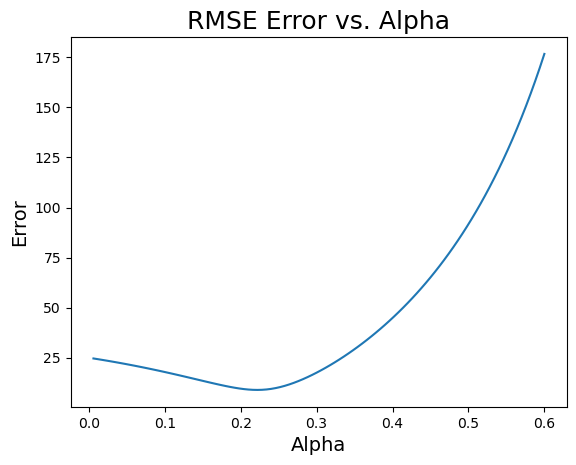

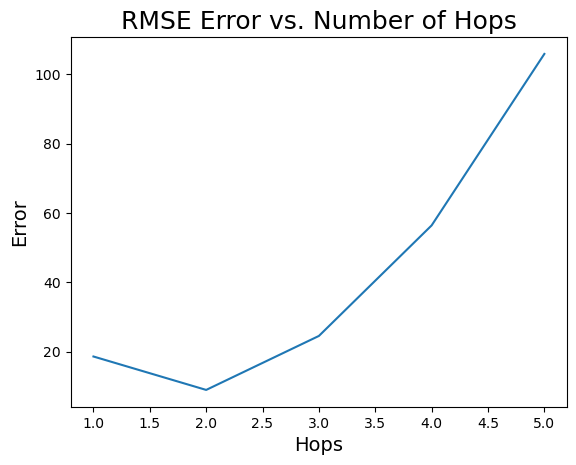

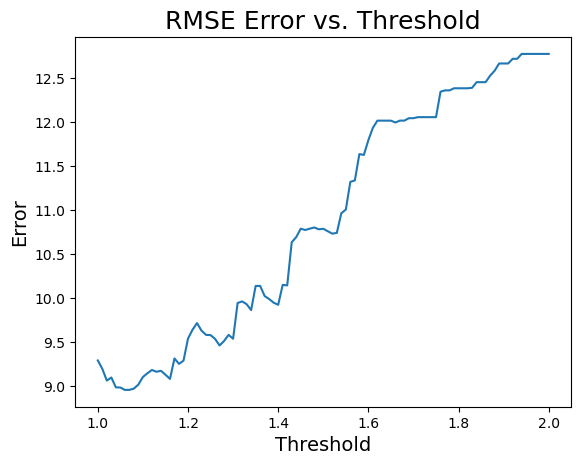

In [55]:
initialise_alpha = 0.2218
initialise_hop = 2
initialise_threshold = 1.06

# Plotting for different parameters

# Plotting for different alpha values
plt.figure(1)
alpha_err = []
alpha_range = np.linspace(0.0, 0.6, 101)
for alpha in alpha_range:
    # Compute error for each alpha value
    err = compute_error(alpha, initialise_threshold, initialise_hop, initial, nan_entries, filled_data, euclidean)
    alpha_err.append(err)
plt.plot(alpha_range, alpha_err)
plt.title('RMSE Error vs. Alpha', fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Error', fontsize=14)

# Plotting for different hop values
plt.figure(2)
hop_err = []
hop_range = np.arange(1, 6)
for L in hop_range:
    # Compute error for each number of hops
    err = compute_error(initialise_alpha, initialise_threshold, L, initial, nan_entries, filled_data, euclidean)
    hop_err.append(err)
plt.plot(hop_range, hop_err)
plt.title('RMSE Error vs. Number of Hops', fontsize=18)
plt.xlabel('Hops', fontsize=14)
plt.ylabel('Error', fontsize=14)

# Plotting for different threshold values
plt.figure(3)
threshold_err = []
threshold_range = np.linspace(1.0, 2.0, 101)
for threshold in threshold_range:
    # Compute error for each threshold value
    err = compute_error(initialise_alpha, threshold, initialise_hop, initial, nan_entries, filled_data, euclidean)
    threshold_err.append(err)
plt.plot(threshold_range, threshold_err)
plt.title('RMSE Error vs. Threshold', fontsize=18)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Error', fontsize=14)

# Assign tuned hyperparameters
alpha_err = np.nan_to_num(alpha_err, nan=np.inf)
hop_err = np.nan_to_num(hop_err, nan=np.inf)
threshold_err = np.nan_to_num(threshold_err, nan=np.inf)

tuned_alpha = alpha_range[np.argmin(alpha_err)]
tuned_hop = hop_range[np.argmin(hop_err)]
tuned_threshold = threshold_range[np.argmin(threshold_err)]

# Additional code to print minimum errors
print('Minimum alpha Error: ', min(alpha_err), 'Tuned alpha: ', tuned_alpha)
print('Minimum L-hops Error: ', min(hop_err), 'Tuned L-hops: ', tuned_hop)
print('Minimum threshold Error: ', min(threshold_err), 'Tuned threshold: ', tuned_threshold)


In [ ]:
# '''
# t_alpha = 0.2218
# t_hop = 2
# t_threshold = 1.06
# '''

# Z, A = compute_progation_matrix(filled_data, euclidean, threshold=t_threshold, L=t_hop, alpha=t_alpha)
# final = []
# for entry in nan_entries:
#     final.append(Z[entry])

# x = np.arange(100)
# plt.figure(figsize=(5, 5))
# plt.scatter(initial, final)
# plt.plot(x, x, color='black')
# plt.title(r'Algorithm evaluation (RMSE = 8.96)')
# plt.xlabel(r'True NO$_2$ concentration ($\mu g/mm^3$)')
# plt.ylabel(r'Propagated NO$_2$ concentration ($\mu g/mm^3$)')

# compute_alpha_error(0.222, 1.06, 2, initial, nan_entries, filled_data, euclidean)

8.95657954286581

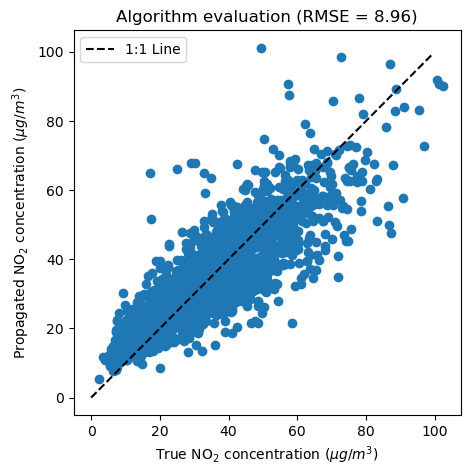

In [59]:
# Plot propagated values against true values

Z, A = compute_propagation_matrix(filled_data, euclidean, threshold=tuned_threshold, L=tuned_hop, alpha=tuned_alpha)
final = [Z[entry] for entry in nan_entries]

x = np.arange(100)
plt.figure(figsize=(5, 5))
plt.scatter(initial, final)
plt.plot(x, x, color='black', linestyle='--', label='1:1 Line')  # Adding a label for the 1:1 line
plt.title(f'Algorithm evaluation (RMSE = {compute_error(tuned_alpha, tuned_threshold, tuned_hop, initial, nan_entries, filled_data, euclidean):.2f})')
plt.xlabel(r'True NO$_2$ concentration ($\mu g/m^3$)')  
plt.ylabel(r'Propagated NO$_2$ concentration ($\mu g/m^3$)')  
plt.legend()  # Displaying the legend

compute_error(tuned_alpha, tuned_threshold, tuned_hop, initial, nan_entries, filled_data, euclidean)


In [58]:
for i in range(len(final)):
    print(f'{initial[i]} -> {final[i]}')

30.491666666666664 -> 33.921152917694386
33.420833333333334 -> 38.783919660266136
19.941666666666666 -> 8.520492277692451
16.504166666666666 -> 19.9351737505321
39.80416666666667 -> 26.956839591715248
16.904166666666665 -> 29.704441338105497
15.470833333333331 -> 13.291840195451702
38.20416666666667 -> 36.07152472558641
37.07916666666667 -> 29.01924836661901
25.333333333333332 -> 30.728572141307765
39.65 -> 50.71662591274258
29.049999999999997 -> 24.294221186497676
15.579166666666671 -> 21.312964114889127
35.58333333333334 -> 34.478154533595124
39.5875 -> 41.81120517029488
26.74166666666667 -> 29.734192859902265
67.85000000000001 -> 62.340146814235275
45.320833333333326 -> 51.119766972533945
16.0 -> 17.02217943101281
28.779166666666665 -> 19.08549668607384
33.00416666666666 -> 46.068929863723454
28.045833333333334 -> 21.177851105247104
12.837499999999999 -> 20.39114736367754
42.69583333333333 -> 39.37425933614519
28.358333333333334 -> 22.06653126596212
55.03749999999999 -> 46.849223564

## Comparison Plots

TEST:
* seed = 1
* alpha = 0.2218
* threshold = 1.06
* L = 2

In [ ]:
# # Plot error against alpha and threshold
# plt.figure(1)

# alpha_range = np.linspace(0.1, 0.5, 50)
# threshold_range = np.linspace(0.5, 2.0, 16)
# L_range = np.arange(1, 6)

# loss = np.zeros((len(alpha_range), len(threshold_range)))
# for i, val1 in enumerate(alpha_range): 
#     for j, val2 in enumerate(threshold_range):
#         val1 = round(val1, 2)
#         val2 = round(val2, 2)
        
#         t_hop = 3
#         loss[i][j] = compute_alpha_error(val1, val2, t_hop, initial, nan_entries, filled_data, euclidean)
        
# X, Y = np.meshgrid(threshold_range, alpha_range)

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# surf = ax.plot_surface(X[:50], Y[:50], loss[:50], cmap='plasma', linewidth=2)
# fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_xlabel('threshold', fontsize=12)
# ax.set_ylabel('alpha', fontsize=12)
# ax.set_zlabel('error', fontsize=12)

# shape = np.unravel_index(loss.argmin(), loss.shape)
# print(f'Threshold: {X[shape]}')
# print(f'Alpha: {Y[shape]}')
# print(f'Error: {np.min(loss)}')

Threshold: 1.1
Alpha: 0.1163265306122449
Minimum RMSE Error: 9.365174127282003


<Figure size 640x480 with 0 Axes>

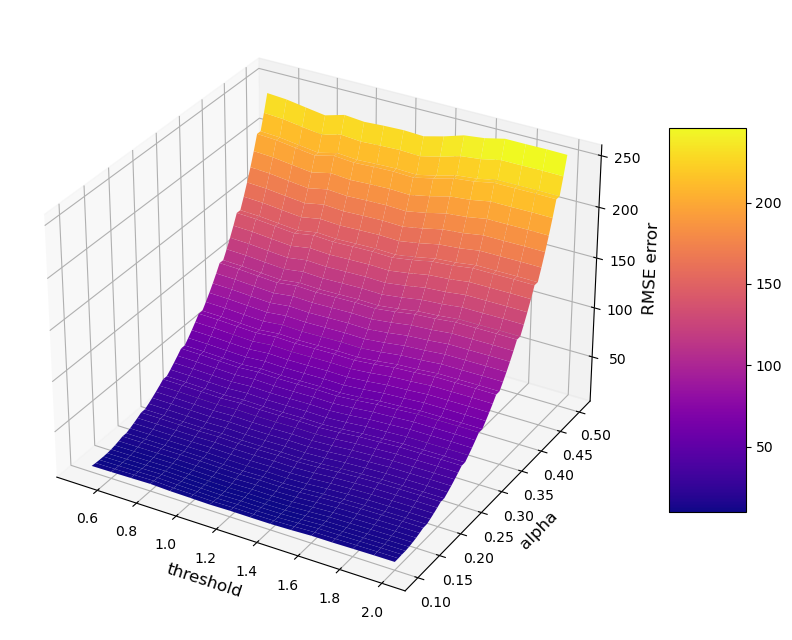

In [79]:
# Plot error against alpha and threshold
error_metric = 'rmse'

plt.figure(1)

# Define the ranges for alpha, threshold, and L (number of hops)
alpha_range = np.linspace(0.1, 0.5, 50)
threshold_range = np.linspace(0.5, 2.0, 16)
L_range = np.arange(1, 6)

# Initialize a 2D array to store error values
loss = np.zeros((len(alpha_range), len(threshold_range)))

# Loop through alpha and threshold combinations
for i, val1 in enumerate(alpha_range): 
    for j, val2 in enumerate(threshold_range):
        val1 = round(val1, 2)
        val2 = round(val2, 2)
        
        # Set a constant value for the number of hops (L)
        t_hop = 3
        
        # Use compute_error function to calculate error for the given parameters
        loss[i][j] = compute_error(val1, val2, t_hop, initial, nan_entries, filled_data, euclidean, error_type=error_metric)
        
# Create meshgrid for 3D plotting
X, Y = np.meshgrid(threshold_range, alpha_range)

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface using the computed error values
surf = ax.plot_surface(X[:50], Y[:50], loss[:50], cmap='plasma', linewidth=2)
fig.colorbar(surf, shrink=0.5, aspect=5)

# Set labels for the axes
ax.set_xlabel('threshold', fontsize=12)
ax.set_ylabel('alpha', fontsize=12)
ax.set_zlabel(f'{error_metric.upper()} error', fontsize=12)

# Find the indices of minimum error
shape = np.unravel_index(loss.argmin(), loss.shape)

# Print the parameters corresponding to the minimum error
print(f'Threshold: {X[shape]}')
print(f'Alpha: {Y[shape]}')
print(f'Minimum {error_metric.upper()} Error: {np.min(loss)}')


Hops: 2
Alpha: 0.22244897959183674
Minimum RMSE Error: 9.106952629393119


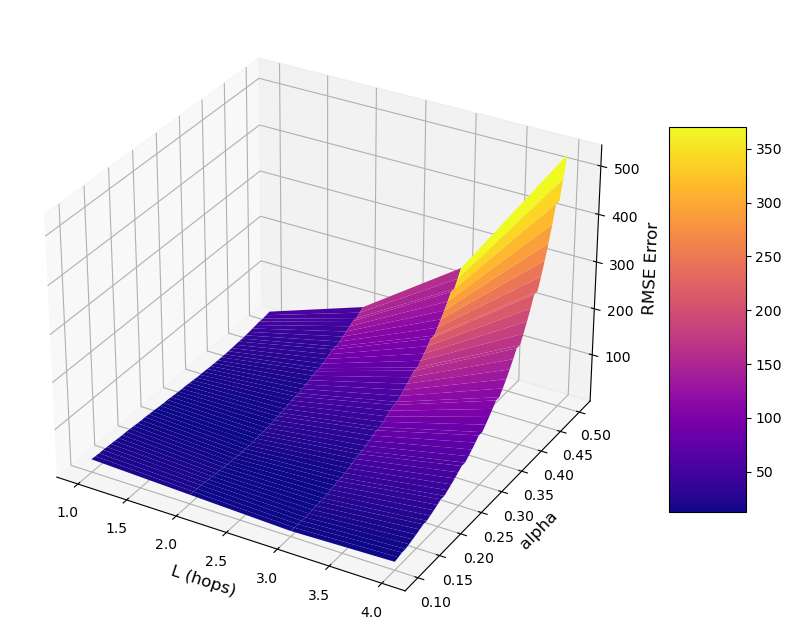

In [76]:
# Plot loss against alpha and L (hops)
error_metric = 'rmse'

alpha_range = np.linspace(0.1, 0.5, 50)
threshold_range = np.linspace(0.5, 2.0, 16)
L_range = np.arange(1, 6)

loss = np.zeros((len(alpha_range), len(L_range)))
for i, val1 in enumerate(alpha_range): 
    for j, val2 in enumerate(L_range):
        val1 = round(val1, 2)
        val2 = round(val2, 2)
        
        t_threshold = 1.1
        # Use compute_error function to calculate error for the given parameters
        loss[i][j] = compute_error(val1, t_threshold, val2, initial, nan_entries, filled_data, euclidean, error_type=error_metric)
        
X, Y = np.meshgrid(L_range, alpha_range)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

lim1 = 50
lim2 = 4
surf = ax.plot_surface(X[:lim1, :lim2], Y[:lim1, :lim2], loss[:lim1, :lim2], cmap='plasma', linewidth=2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('L (hops)', fontsize=12)
ax.set_ylabel('alpha', fontsize=12)
ax.set_zlabel(f'{error_metric.upper()} Error', fontsize=12)  # Display the error metric in uppercase

shape = np.unravel_index(loss.argmin(), loss.shape)
print(f'Hops: {X[shape]}')
print(f'Alpha: {Y[shape]}')
print(f'Minimum {error_metric.upper()} Error: {np.min(loss)}')


Hops: 2
Threshold: 1.0566037735849056
Minimum RMSE Error: 8.95657954286581


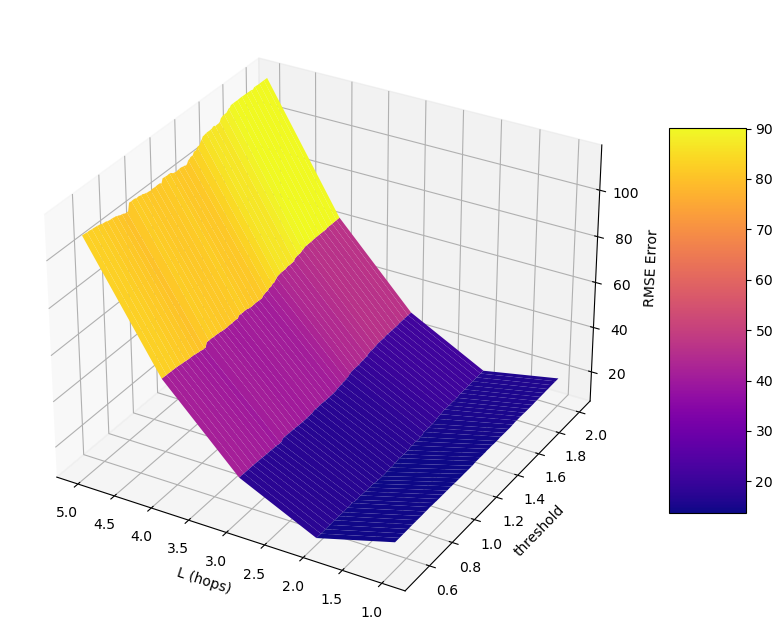

In [78]:
# Plot loss against threshold and L (hops)
error_metric = 'rmse'

alpha_range = np.linspace(0.1, 1.0, 10)
threshold_range = np.linspace(0.5, 2.0, 160)
L_range = np.arange(1, 6)

loss = np.zeros((len(threshold_range), len(L_range)))
for i, val1 in enumerate(threshold_range): 
    for j, val2 in enumerate(L_range):
        val1 = round(val1, 2)
        val2 = round(val2, 2)
        
        t_alpha = 0.222
        # Use compute_error function to calculate error for the given parameters
        loss[i][j] = compute_error(t_alpha, val1, val2, initial, nan_entries, filled_data, euclidean, error_type=error_metric)
        
X, Y = np.meshgrid(L_range, threshold_range)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

lim1 = len(threshold_range)
lim2 = len(L_range)
surf = ax.plot_surface(X[:lim1, :lim2], Y[:lim1, :lim2], loss[:lim1, :lim2], cmap='plasma', linewidth=2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.invert_xaxis()
ax.set_xlabel('L (hops)')
ax.set_ylabel('threshold')
ax.set_zlabel(f'{error_metric.upper()} Error')  # Display the error metric in uppercase

shape = np.unravel_index(loss.argmin(), loss.shape)
print(f'Hops: {X[shape]}')
print(f'Threshold: {Y[shape]}')
print(f'Minimum {error_metric.upper()} Error: {np.min(loss)}')


In [80]:
np.mean(initial)

34.41311481063082

In [81]:
print(compute_error(0.12, 1.3, 3, initial, nan_entries, filled_data, euclidean, error_type='rmse'))
print(compute_error(0.22, 1.3, 2, initial, nan_entries, filled_data, euclidean, error_type='rmse'))
print(compute_error(0.22, 1.1, 2, initial, nan_entries, filled_data, euclidean, error_type='rmse'))

9.691639738016121
9.536098303558013
9.106952629393119


In [82]:
rmse_err = compute_error(0.2218, 1.06, 2, initial, nan_entries, filled_data, euclidean, error_type='rmse')
smape_err = compute_error(0.2218, 1.06, 2, initial, nan_entries, filled_data, euclidean, error_type='smape')
print(f'RMSE Error: {rmse_err}')
print(f'SMAPE Error: {smape_err}')

RMSE Error: 8.956522760081501
SMAPE Error: 0.2139945849545943


## Scale to full dataset

In [83]:
full_data, similarity = fill_and_refactor(grouped)

In [84]:
# full_data
am = ComputeAM(full_data)
euclidean_am = am.euclidean_dist(full_data)
euclidean_am

,TD0,BG3,BG1,BG2,BN2,BN3,BN1,BX5,BX2,BQ7,...,MY1,WM6,WMZ,WMB,CE1,NB1,WM8,WM9,VS1,CE2
TD0,0.000000,3549.116598,2685.747672,2026.109859,1723.219571,2160.480198,3790.516552,2364.543690,1473.988806,2278.337519,...,7343.619528,11427.012456,10335.182239,6022.655404,1769.714183,8695.134082,3577.639465,3089.948785,1690.480298,1766.709384
BG3,3549.116598,0.000000,2846.479141,2635.765618,3156.457543,3723.379866,2768.023650,2972.470490,3340.498477,2119.103319,...,5835.055223,9328.925045,8455.508045,4688.786346,4044.412115,6953.881861,4290.555871,3874.454547,3765.264434,3342.042101
BG1,2685.747672,2846.479141,0.000000,2251.122824,2601.436960,3358.036627,3293.377267,1398.201789,2564.425116,2276.611243,...,6451.934975,10316.712503,9294.642419,5186.089488,3180.859918,7682.863710,3631.789083,3246.862621,3048.086065,2644.834698
BG2,2026.109859,2635.765618,2251.122824,0.000000,1451.286755,1756.803310,2610.422549,1967.267156,1508.118324,1190.930212,...,6066.238143,10157.631687,9053.850232,4651.690068,2232.491948,7355.326726,2631.181052,2192.299375,1955.174074,1349.717636
BN2,1723.219571,3156.457543,2601.436960,1451.286755,0.000000,1299.256129,2877.365079,2177.159310,1262.192968,1835.629208,...,6386.007864,10785.416823,9605.801068,5203.080196,1788.987318,7936.186502,2591.504831,2095.787736,1549.655132,1119.899837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB1,8695.134082,6953.881861,7682.863710,7355.326726,7936.186502,7966.795152,5657.092119,7713.727709,8199.598827,7203.361708,...,3524.352847,3576.169907,2274.298785,3023.263892,9232.578575,0.000000,6983.236924,7238.537568,8883.377429,8011.927804
WM8,3577.639465,4290.555871,3631.789083,2631.181052,2591.504831,2282.075445,3082.579586,3032.627283,2953.269060,2979.702814,...,5706.816700,10094.171641,8688.466925,4287.708266,3313.539963,6983.236924,0.000000,984.690203,3100.268643,2335.267723
WM9,3089.948785,3874.454547,3246.862621,2192.299375,2095.787736,1820.308598,2927.103807,2603.106107,2503.627881,2508.378552,...,5931.610231,10299.126629,8944.438327,4534.180192,2757.021992,7238.537568,984.690203,0.000000,2545.367584,1782.677541
VS1,1690.480298,3765.264434,3048.086065,1955.174074,1549.655132,1438.645787,3913.279845,2413.613413,1672.981352,2282.273684,...,7404.865493,11730.053380,10569.787310,6112.356380,656.442132,8883.377429,3100.268643,2545.367584,0.000000,1013.881920


In [85]:
print(tuned_alpha)
print(tuned_hop)
print(tuned_threshold)

0.222
2
1.06


In [88]:
Z, A = compute_propagation_matrix(full_data, similarity, threshold=tuned_threshold, L=tuned_hop, alpha=tuned_alpha)

# HOURLY
# Z, A = compute_propagation_matrix(full_data, similarity, threshold=1.66, L=2, alpha=0.216)

In [89]:
corrected = np.copy(Z)

In [90]:
for (i, column) in enumerate(grouped):
    for (j, entry) in enumerate(np.asarray(grouped[column])): 
        if not np.isnan(entry):
            corrected[j][i] = entry
#     print(np.count_nonzero(np.isnan(np.asarray(grouped[column]))))
#     break    

In [91]:
corrected == Z
# print(grouped.isna().sum().sum())
# print(grouped.size)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True, False],
       [ True,  True, False, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [92]:
#Get similarity matrix from propagated data

corrected_df = pd.DataFrame(corrected, columns=grouped.columns.unique(), index=grouped.index.unique())
fd1, similarity = fill_and_refactor(corrected_df)

In [93]:
propagated_df = pd.DataFrame(corrected, columns = grouped.columns.unique(), index = grouped.index.unique())
propagated_df

,TD0,BG3,BG1,BG2,BN2,BN3,BN1,BX5,BX2,BQ7,...,MY1,WM6,WMZ,WMB,CE1,NB1,WM8,WM9,VS1,CE2
date,,,,,,,,,,,,,,,,,,,,,
1996-01-01,37.507581,52.233017,56.168644,47.731189,43.188308,37.796410,60.934612,55.190789,40.979851,49.284198,...,62.923796,136.822020,134.693071,76.450214,33.796686,116.191098,46.501742,46.344521,36.208572,42.973436
1996-01-02,37.292531,51.977328,55.934184,47.499557,42.958234,37.559611,60.647386,54.962401,40.753224,49.052444,...,62.903320,136.822020,134.693071,76.322768,33.637675,116.181048,46.218659,46.093412,36.043127,42.735083
1996-01-03,37.333302,52.024634,55.989020,47.552799,43.009540,37.620218,60.792011,55.011730,40.799562,49.106129,...,62.922385,136.822020,134.693071,76.453414,33.636444,116.190786,46.341745,46.174366,36.047729,42.796714
1996-01-04,37.054024,51.813521,55.704618,47.240483,42.697558,37.309992,60.473896,54.700447,40.487856,48.794181,...,62.889631,136.822020,134.693071,76.211265,33.413268,116.171000,46.016810,45.844735,35.819647,42.486752
1996-01-05,36.794620,51.693036,55.459205,46.999012,42.456823,37.066789,60.262052,54.459918,40.247479,48.552484,...,62.889739,136.822020,134.693071,76.092315,33.164455,116.168222,45.789006,45.603159,35.572210,42.244118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,26.584611,25.099513,24.366667,27.545833,34.799909,35.724431,43.078017,33.733327,22.212500,20.458333,...,33.345833,39.875000,50.410340,35.991667,27.179515,42.279167,49.093869,47.304713,29.360315,35.054167
2020-12-29,24.340444,23.076929,17.800000,21.562500,32.467785,33.437571,40.751812,31.391597,21.145833,20.295833,...,28.591667,38.141667,49.405880,31.900000,25.038020,35.045833,46.826891,44.984547,27.110286,31.183333
2020-12-30,30.124256,28.398039,43.995833,37.029167,38.657695,39.414724,47.262635,37.465465,38.704167,39.708333,...,51.679167,54.275000,53.496910,45.766667,56.890909,51.512500,52.975002,51.266108,32.840771,44.250000


In [94]:
def group_dataframe(df, freq='M'):
    grouped_df = df.copy() 
    grouped_df = grouped_df.reset_index(level=0)
    grouped_df['date'] = pd.to_datetime(grouped_df.date)
    grouped_df = grouped_df.groupby(pd.Grouper(key="date", freq=freq)).mean()
    return grouped_df

In [ ]:
# propagated_df.to_csv('complete_NO2.csv')

In [95]:
inds = [0, 25, 50, 75, 100, 125, 150, 175, 200]
vals = [np.array(similarity.columns)[i] for i in inds] 
vals

['TD0', 'BL0', 'EA7', 'HF2', 'IS6', 'HP1', 'SK2', 'WAC', 'CE2']

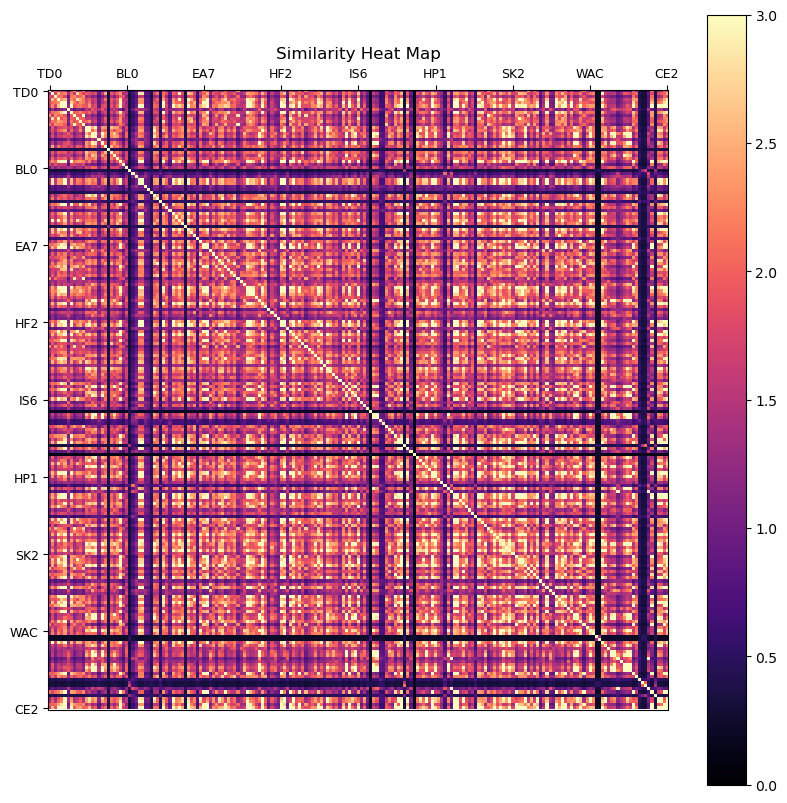

In [96]:
plt.figure(figsize=(10, 10))
sim_heat = np.fill_diagonal(similarity.values, 3)
plt.imshow(similarity, cmap='magma', interpolation='nearest', vmin=0, vmax=3)
plt.title('Similarity Heat Map')
plt.xticks(plt.xticks()[0][1:10], labels=vals[:9], fontsize=9)
plt.yticks(plt.yticks()[0][1:10], labels=vals[:9], fontsize=9)
# print(plt.xticks()[0].size)
plt.tick_params(top=True, labeltop=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.colorbar()
plt.show()

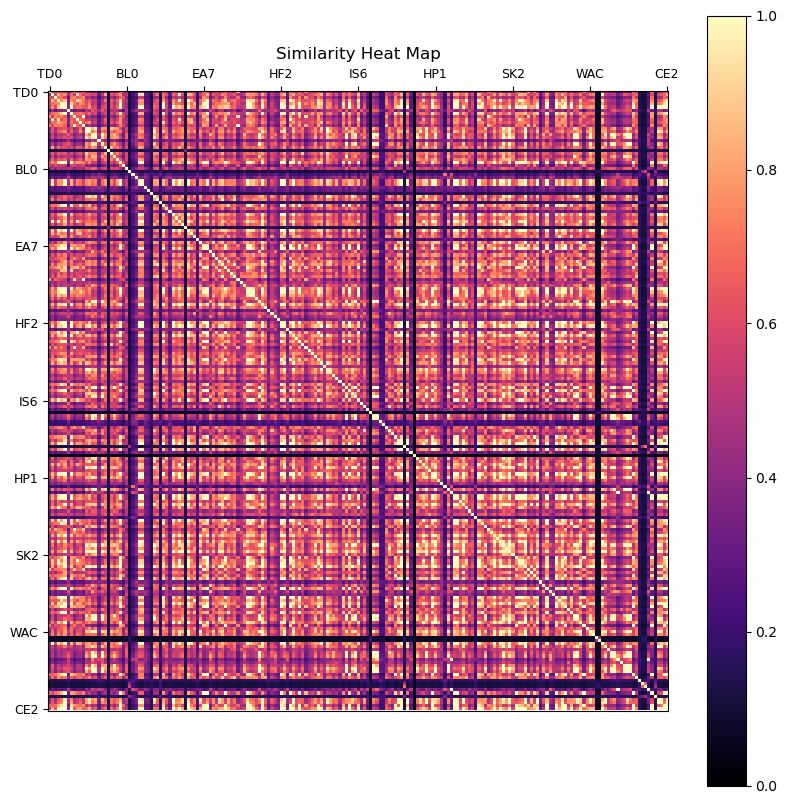

In [97]:
plt.figure(figsize=(10, 10))
sim_heat = np.fill_diagonal(similarity.values, 3)
plt.imshow(similarity/3, cmap='magma', interpolation='nearest', vmin=0, vmax=1)
plt.title('Similarity Heat Map')
plt.xticks(plt.xticks()[0][1:10], labels=vals[:9], fontsize=9)
plt.yticks(plt.yticks()[0][1:10], labels=vals[:9], fontsize=9)
# print(plt.xticks()[0].size)
plt.tick_params(top=True, labeltop=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.colorbar()
plt.show()

## Setup

In [ ]:
similarity

In [ ]:
species = "NO2"
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"

In [ ]:
# Get LAQN site codes
url_sites = f"http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName={region}/Json"
               
london_sites = requests.get(url_sites)
sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
site_codes = sites_df["@SiteCode"].tolist()
print(len(site_codes))

In [ ]:
# Get sites for each local authority
site_map = {} # map between local authority codes and list of sites belonging to that local authority
location_map = {} # map between local authority codes and local authority names
# local_codes = set(sites_df['@LocalAuthorityCode'].unique()) # 1 - 33
for i in range(1, 34):
    code = str(i)
    location_map[code] = sites_df[sites_df['@LocalAuthorityCode'] == code]['@LocalAuthorityName'].unique()[0]
    res = sites_df[sites_df['@LocalAuthorityCode'] == code]['@SiteCode']
    site_map[code] = []
    for j, site in res.items():
        site_map[code].append(site)

In [ ]:
propagated_df

## Time Series Plots (grouped by day)

In [ ]:
dates = propagated_df.index.values
stations = {'TD0', 'EN5', 'BN1', 'SK2', 'KC2', 'HI2'}
while len(stations) < 10:
    sample = np.random.choice(data.df.columns.values[1:], 1)[0]
    stations.add(sample)
    
for index, station in enumerate(stations):
    plt.figure(index, figsize=(12, 4))
    plt.plot(dates, propagated_df[station].values, color='black', linestyle='dotted')
    plt.plot(dates, grouped[station].values, color='black')
    plt.title(f'Station: {station}')
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)

In [ ]:
dates = propagated_df.index.values
stations = {'TD0', 'EN5', 'BN1', 'SK2', 'KC2', 'HI2', 'ME1'}
while len(stations) < 10:
    sample = np.random.choice(data.df.columns.values[1:], 1)[0]
    stations.add(sample)

start = 2000
add = 300
for index, station in enumerate(stations):
    plt.figure(index, figsize=(12, 4))
    plt.plot(dates[start:start+add], propagated_df[station].values[start:start+add], color='black', linestyle='dotted')
    plt.plot(dates[start:start+add], grouped[station].values[start:start+add], color='black')
    plt.title(f'Station: {station}')
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)

## Time Series Plots (grouped by week)

In [ ]:
grouped_W = group_dataframe(grouped, 'W')
propagated_df_W = group_dataframe(propagated_df, 'W')
# grouped_W
propagated_df_W

In [ ]:
dates = propagated_df_W.index.values
stations = {'TD0', 'EN5', 'BN1', 'SK2', 'KC2', 'HI2'}
while len(stations) < 10:
    sample = np.random.choice(data.df.columns.values[1:], 1)[0]
    stations.add(sample)
    
for index, station in enumerate(stations):
    plt.figure(index, figsize=(12, 4))
    plt.plot(dates, propagated_df_W[station].values, color='black', linestyle='dotted')
    plt.plot(dates, grouped_W[station].values, color='black')
    plt.title(f'Station: {station}')
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)

## Time Series Plots (grouped by month)

In [ ]:
grouped_M = group_dataframe(grouped, 'M')
propagated_df_M = group_dataframe(propagated_df, 'M')
grouped_M

In [ ]:
dates = propagated_df_M.index.values

### Find dates where months have missing data
missing_dates = grouped.loc[pd.isna(grouped['TD0']), :].index

In [ ]:
# GET MISSING DATA PER MONTH

years = np.arange(1996, 2021)
months = np.arange(1, 13)

def missing_data_count(df):
    grouped_M = group_dataframe(df, 'M')
    res = pd.DataFrame(index=grouped_M.index, columns=grouped_M.columns)
    
    stations = df.columns.tolist()
    test = df.reset_index(level=0)
    
    i = 0
    for year in years:
        for month in months:
            sample_df = test[(test['date'].dt.year == year) & (test['date'].dt.month == month)]
            res.iloc[i] = sample_df.isna().sum().tolist()[1:]
            i += 1

    return res

def get_missing_dates(df, station):
    station_data = df[station]
    grouped_missing = station_data[station_data.isnull()]
    grouped_missing.iloc[:] = 1.0
    grouped_M_missing = group_dataframe(grouped_missing, 'M')
    test = grouped_M_missing.reset_index(level=0)
    missing_dates = test[test[station] == 1.0]['date'].tolist()
    return missing_dates

In [ ]:
miss_count = missing_data_count(grouped)
# res.to_csv('random.csv')

missing_dates = get_missing_dates(grouped, 'TD0')
propagated_df_M['TD0'][missing_dates].values

In [ ]:
dates

In [ ]:
dates = propagated_df_M.index.values
stations = {'TD0', 'EN5', 'BN1', 'SK2', 'KC2', 'HI2', 'RI2', 'WM6', 'EA1'}
while len(stations) < 20:
    sample = np.random.choice(data.df.columns.values[1:], 1)[0]
    stations.add(sample)
    
for index, station in enumerate(stations):
    plt.figure(figsize=(12, 4))
    plt.plot(dates, propagated_df_M[station].values, color='black', linestyle='dotted')
    plt.plot(dates, grouped_M[station].values, color='black')
    plt.title(f'Station: {station}')
    plt.xlabel('date', fontsize=12)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

In [ ]:
dates = propagated_df_M.index.values
stations = {'TD0', 'EN5', 'BN1', 'SK2', 'KC2', 'HI2', 'RI2'}
while len(stations) < 10:
    sample = np.random.choice(data.df.columns.values[1:], 1)[0]
    stations.add(sample)
    
for index, station in enumerate(stations):
    plt.figure(figsize=(12, 4))
#     plt.plot(dates, propagated_df_M[station].values, color='black', linestyle='dotted')
    plt.plot(dates, grouped_M[station].values, color='black')
    plt.plot(dates, [np.nanmean(grouped_M[station].values)]*301 , color='red', alpha= 0.0)
    plt.title(f'Station: {station}')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
#     plt.xlim(date(1996, 1, 1), date(2021, 1, 1))

In [ ]:
dates = propagated_df_M.index.values
stations = {'TD0', 'EN5', 'BN1', 'SK2', 'KC2', 'HI2'}
while len(stations) < 20:
    sample = np.random.choice(data.df.columns.values[1:], 1)[0]
    stations.add(sample)
    
for index, station in enumerate(stations):
    plt.figure(2*index, figsize=(12, 4))
    plt.plot(dates, propagated_df_M[station].values, color='black', linestyle='dotted')
    plt.plot(dates, grouped_M[station].values, color='black')
    
    missing_dates = get_missing_dates(grouped, station)
    plt.scatter(missing_dates, propagated_df_M[station][missing_dates].values, marker='o', color='r', s = 3.0)
    
    plt.title(f'Station: {station}')
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)
    
    plt.figure(2*index+1, figsize=(12, 4))
    plt.scatter(dates, propagated_df_M[station].values, c=miss_count[station].values, marker='o', s=5.0, cmap='viridis')
    plt.title(f'Station: {station}')
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)
    plt.colorbar()

### Borough Plots

In [ ]:
grouped

In [ ]:
prop_cycle = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [ ]:
dates = propagated_df_M.index.values
for i in range(1, 34):
    code = str(i)
    cols = [site for site in site_map[code] if site in propagated_df_M.columns]
#     for col in cols
    plt.figure(figsize=(10, 4))
    for j, col in enumerate(cols):
        color = prop_cycle[j % len(prop_cycle)]
        plt.plot(dates, grouped_M[col].values, color=color, label=f'{col}', linewidth=1)
        plt.plot(dates, propagated_df_M[col].values, color=color, linestyle='dashed', linewidth=1)
    plt.title(f'{location_map[code]}', fontsize=13)
    plt.ylabel("NO$_{2}$ Concentrations (µg/m$^3$)", fontsize=11)
    plt.xlabel("Date", fontsize=11)
    plt.legend()
    
    #     ax = propagated_df_M[cols].plot(figsize=(10, 4), title=f'{location_map[code]}', fontsize=5)
#     ax.set_title(f'{location_map[code]}', fontsize=13)
#     ax.set_ylabel("NO$_{2}$ Concentrations (µg/m$^3$)", fontsize=11)
#     ax.set_xlabel("Date", fontsize=11)
#     ax.tick_params(axis='both', which='major', labelsize=9.5)

In [ ]:
dates = propagated_df_M.index.values
for i in range(1, 34):
    code = str(i)
    cols = [site for site in site_map[code] if site in propagated_df_M.columns]
#     for col in cols
    plt.figure(figsize=(10, 4))
    for j, col in enumerate(cols):
        color = prop_cycle[j % len(prop_cycle)]
        plt.plot(dates, grouped_M[col].values, color=color, label=f'{col}', linewidth=1)
#         plt.plot(dates, propagated_df_M[col].values, color=color, linestyle='dashed', linewidth=1)
    plt.title(f'{location_map[code]}', fontsize=13)
    plt.ylabel("NO$_{2}$ Concentrations (µg/m$^3$)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend()

### Similar Station Plots

In [ ]:
similar_stations = {}
for station in A.columns:
    similar_stations[station] = similarity[station].sort_values(ascending=False)[:5].index.tolist()

In [ ]:
colour_cycle = prop_cycle = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
plotted_stations = set()

i = 0
for station, similars in similar_stations.items():
    plotted_stations.add(station)
    
    plt.figure(i, figsize=(12, 4))
    plt.plot(dates, propagated_df_M[station].values, label=station, color=colour_cycle[0])
    for j, similar in enumerate(similars):
        plt.plot(dates, propagated_df_M[similar].values, label=similar, color=colour_cycle[j+1])
    plt.title(f'Similar stations to {station}')
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)
    plt.legend()
    
    plt.figure(i+1, figsize=(12, 4))
    plt.plot(dates, grouped_M[station].values, label=station, color=colour_cycle[0])
    for j, similar in enumerate(similars):
        plt.plot(dates, grouped_M[similar].values, label=similar, color=colour_cycle[j+1])
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)
    plt.legend()
    
    i += 2
    if i == 40:
        break

In [ ]:
colour_cycle = prop_cycle = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
plotted_stations = set()

i = 0
for station, similars in similar_stations.items():
    plotted_stations.add(station)
    
    plt.figure(i, figsize=(12, 4))
#     plt.plot(dates, grouped_M[station].values, color=colour_cycle[0], label=f'{station}', linewidth=1)
#     plt.plot(dates, propagated_df_M[station].values, color=colour_cycle[0], linestyle='dashed', linewidth=1)
    for j, similar in enumerate(similars):
        plt.plot(dates, grouped_M[similar].values, color=colour_cycle[j+1], label=f'{similar}', linewidth=1)
        plt.plot(dates, propagated_df_M[similar].values, color=colour_cycle[j+1], linestyle='dashed', linewidth=1)
#         plt.plot(dates, propagated_df_M[similar].values, label=similar, color=colour_cycle[j+1])
#     plt.title(f"Stations similar to: '{station}'")
    plt.xlabel('date', fontsize=10)
    plt.ylabel('NO$_{2}$ Concentrations (µg/m$^3$)', fontsize=10)
    plt.legend()
    
    plt.figure(i+1)
    similarity_list = similarity[station]
    london_sites_gdf_sim = london_sites_gdf.copy()
    london_sites_gdf_sim['Similarity'] = np.nan
    for index, sim_val in similarity_list.items():
        london_sites_gdf_sim.loc[london_sites_gdf_sim['@SiteCode'] == index, 'Similarity'] = sim_val
    london_sites_gdf_sim = london_sites_gdf_sim[~london_sites_gdf_sim['Similarity'].isna()]

    plot_on_map(london_sites_gdf_sim, london_gdf, data_column='Similarity', colorbar=True,
                title=f"Similarity map: '{station}'", 
                data_markersize=5, fontsize=15,
                map_edge_color="gray", figsize=(15,7), axis="on", mark=station)
    
    
    i += 2
    if i == 20:
        break

## Plot similar stations on land use map 

In [ ]:
# Load LAQN metadata
london_landuse = gpd.read_file(path.join(folder, "gis_osm_landuse_a_free_1.shp"))
print(london_landuse.shape)

In [ ]:
london_landuse

In [ ]:
london_landuse.plot(figsize=(10,10), column='fclass', legend=True, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})
plt.title('Greater London Land-use Map')

In [ ]:
land_palette = {
    'allotments': '#002fff',
    'cemetery': 'gray',
    'commercial': 'orange',
    'farmland': '#002fff',
    'farmyard': '#002fff',
    'forest': 'green',
    'grass': 'green',
    'heath': 'green',
    'industrial': '#4B0092',
    'meadow': 'green',
    'military': '#4B0092',
    'nature_reserve': 'green',
    'orchard': 'pink',
    'park': 'green',
    'quarry': 'gray',
    'recreation_ground': 'green',
    'residential': '#E3E3E3',
    'retail': 'orange',
    'scrub': 'green',
}
cmap = matplotlib.colors.ListedColormap([color for key, color in land_palette.items()])

london_landuse.plot(figsize=(10,10), column='fclass', legend=True, cmap=cmap, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})
plt.title('Greater London Land-use Map')

In [ ]:
def plot_on_osm_map(data_geodataframe, map_geodataframe, cmap, figsize=(20,10), colorbar=False, data_column='Similarity', title='LAQN Monitoring Station Distribution', mark=None, similars=None):
    
    base = data_geodataframe.plot(ax=map_geodataframe.plot(figsize=figsize, 
                                           column='fclass',
                                           legend=False,
                                           cmap=cmap,
                                           alpha=0.5,
                                           legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)}),
                    color='black', marker='x', markersize=75, linewidths=3)
    
    if colorbar:
        colorbar_max = data_geodataframe[data_column].max()
        norm = plt.Normalize(data_geodataframe[data_column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=None, 
        norm=norm)).set_label(data_column)
        
    if mark:
        marked = data_geodataframe[data_geodataframe['@SiteCode'] == mark]
        marked.plot(ax=base, marker='o', color='black', markersize=100);

    if mark and similar:
        title = f'{title}\n Similar stations: {similars}'
    
    plt.suptitle(title, fontsize=20)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis("on")
    plt.savefig(f'images/{mark}_similarity.png')
    plt.show()
    

In [ ]:
similarity.max().max()

In [ ]:
# # Get similarity maps

# for station, similars in similar_stations.items():
#     similarity_list = similarity[station]
#     london_sites_gdf_sim = london_sites_gdf.copy()
#     london_sites_gdf_sim['Similarity'] = np.nan
#     for index, sim_val in similarity_list.items():  
#         #ensure current station is most similar
#         if index == station:
#             london_sites_gdf_sim.loc[london_sites_gdf_sim['@SiteCode'] == index, 'Similarity'] = 100
#         else:
#             london_sites_gdf_sim.loc[london_sites_gdf_sim['@SiteCode'] == index, 'Similarity'] = sim_val
        
#     london_sites_gdf_sim = london_sites_gdf_sim[~london_sites_gdf_sim['Similarity'].isna()]
    
#     # MAP N MOST SIMILAR STATIONS
# #     data_count=10
# #     london_sites_gdf_sim = london_sites_gdf_sim.sort_values(by='Similarity', ascending=False)[:data_count]
    
#     # ... OR MAP STATIONS > 0.9*MAX
#     max_similarity = london_sites_gdf_sim.sort_values(by='Similarity', ascending=False).iloc[1]['Similarity']
#     london_sites_gdf_sim = london_sites_gdf_sim.loc[(london_sites_gdf_sim['Similarity'] >= 0.9*max_similarity)]
      
#     similars = london_sites_gdf_sim['@SiteCode'].values
#     similars = np.setdiff1d(similars, station)
#     plot_on_osm_map(london_sites_gdf_sim[:11], london_landuse, cmap, mark=station, title=f'LAQN NO$_2$ Dataset - Station {station}', similars=similars[:10])

### Tests

In [ ]:
# Find stations in common: WA7 == WA8, LB4, KC5, WM6 == WMZ, NB1

stations = ['CD4', 'CD5', 'WA7', 'WA8', 'WM6', 'WMZ', 'CD9', 'KT3', 'NB1']
for i in stations:
    test = london_sites_gdf[london_sites_gdf['@SiteCode'] == i]
    plot_on_osm_map(test, london_landuse, cmap, title = i)

In [ ]:
np.mean(similarity).sort_values(ascending=True)[:20]

In [ ]:
similar_stations

In [ ]:
# count of similar stations over all stations
similar_station_count = {}

for station in A.columns:
    data_count = 10
    similars = similarity[station].sort_values(ascending=False)[:data_count].index.tolist()
    
    if station == 'TD0':
        print(similars)
    
    for i in similars:
        if i not in similar_station_count:
            similar_station_count[i] = 0
        similar_station_count[i] += 1

In [ ]:
similar_station_count

In [ ]:
grouped

In [ ]:
stations = ['CD4', 'CD5']
grouped[stations].to_csv('random.csv')